In [1]:
%%HTML
<style>
.container { width:100% } 
</style>

# Handwritten Digit Recognition

In this notebook we show how feed-forward neural networks can be used to recognize handwritten digits.

The data that we are using is stored in a <a href="https://docs.python.org/3/library/gzip.html">gzipped</a>, 
<a href="https://docs.python.org/3/library/pickle.html">pickled</a> file.  Therefore, we need to import the corresponding libraries to access the data. 

In [2]:
import gzip
import pickle

As our data is stored as tuples of `numpy` arrays, we have to import numpy.

In [3]:
import numpy as np

In order to be able to show the images of the handwritten digits, we use `matplotlib`.

In [4]:
import matplotlib.pyplot as plt

We need to import the module `random` as we are using <em style="color:blue">stochastic gradient descent</em> to compute the weights of our neural network.

In [5]:
import random

The function $\texttt{vectorized_result}(d)$ converts a digit $d \in \{0,\cdots,9\}$ into a `numpy` array $\mathbf{x}$ of shape $(10, 1)$ such that we have
$$
\mathbf{x}[i] = 
\left\{
  \begin{array}{ll}
     1 & \mbox{if $i = d$;} \\
     0 & \mbox{otherwise}
  \end{array}  
\right.
$$
for all $i \in \{0,\cdots,9\}$.
This function is used to convert a digit $d$ into the expected output of a neural network that has an output unit for every digit.

In [6]:
def vectorized_result(d):
    e    = np.zeros((10, 1), dtype=np.float32)
    e[d] = 1.0
    return e

In [7]:
vectorized_result(2)

array([[0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

The file `mnist.pkl.gz` contains a triple of the form
```
train, validate, test
```
Here `train` is a pair of the form `(X, y)` where
- `X` is a numpy array of shape `(50000, 784)`,
- `y` is a numpy array of shape `(50000, )`.

For every $i \in \{0,\cdots, 49,000\}$ we have that $\textbf{X}[i]$ is an image of a handwritten digit and $\textbf{y}[i]$ is a digit, i.e. an element of the set 
$\{0,\cdots,9\}$.

The structure of `validate` and `test` is similar, but these contain only $10,000$ images each.

The function $\texttt{load_data}()$ returns a pair of the form
$$ (\texttt{training_data}, \texttt{test_data}) $$
where 
- $\texttt{training_data}$ is a list containing 50,000 pairs $(\textbf{x}, \textbf{y})$       s.t. 
  - $\textbf{x}$ is a 784-dimensional `numpy.ndarray` containing the input image, and   
  - $\textbf{y}$ is a 10-dimensional `numpy.ndarray` corresponding to the correct digit for 
    $\textbf{x}$.   
- To keep things simple, we do not use the validation data.
- $\texttt{test_data}$ is a list containing 10,000 pairs $(\textbf{x}, y)$.  In each case, 
  $\textbf{x}$ is a 784-dimensional `numpy.ndarray` containing the input image, 
  and $y \in \{0,\cdots,9\}$ is the corresponding digit value.

Note that the formats for training data and test data are different.  For the training data $\textbf{y}$ is a vector, but for the test data $y$ is a number.

In [9]:
def load_data():
    with gzip.open('mnist.pkl.gz', 'rb') as f:
        train, validate, test = pickle.load(f, encoding="latin1")
    print(f'shape of training data: {(train[0].shape, train[1].shape)}')
    training_inputs    = [np.reshape(x, (784, 1)) for x in train[0]]
    training_results   = [vectorized_result(y) for y in train[1]]
    training_data      = list(zip(training_inputs, training_results))
    test_inputs        = [np.reshape(x, (784, 1)) for x in test[0]]
    test_data          = list(zip(test_inputs, test[1]))
    return training_data, test_data

In [8]:
list(zip([1, 2], ['a', 'b']))

[(1, 'a'), (2, 'b')]

We store the data in two variables: `training_data` and `test_data`. 
- `training_data` is a list of pairs of the form $(\textbf{x}, \textbf{y})$ where 
   $\textbf{x}$ is a `numpy` array of shape $(784, 1)$ representing the image of a digit, 
   while $\textbf{y}$ is a `numpy` array of shape $(10, 1)$ that is a 
   <a href="https://en.wikipedia.org/wiki/One-hot">one-hot encoding</a> 
   of the digit shown in $\textbf{x}$.
- `test_data` is a list of pairs of the form $(\textbf{x}, y)$ where 
   $\textbf{x}$ is a `numpy` array of shape $(784, 1)$ representing the image of a digit, 
   while $y$ is an element of the set $\{0,\cdots,9\}$.

In [10]:
%%time
training_data, test_data = load_data()

shape of training data: ((50000, 784), (50000,))
CPU times: user 3.33 s, sys: 244 ms, total: 3.57 s
Wall time: 3.67 s


The function $\texttt{show_digit}(\texttt{row}, \texttt{columns}, \texttt{offset})$ 
shows $\texttt{row} \cdot \texttt{columns}$ images of the training data.  The first image shown is the image at index $\texttt{offset}$.

In [11]:
def show_digits(rows, columns, offset=0):
    f, axarr = plt.subplots(rows, columns)
    for r in range(rows):
        for c in range(columns):
            i     = r * columns + c + offset
            image = 1 - training_data[i][0]
            image = np.reshape(image, (28, 28))
            axarr[r, c].imshow(image, cmap="gray")
            axarr[r, c].axis('off')
    # plt.savefig("digits.pdf")    
    plt.show()

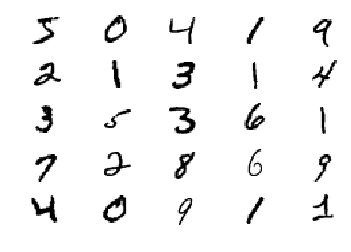

In [13]:
show_digits(5, 5, 0)

Our goal is to find the <em style="color:blue;">weight matrices</em> and <em style="color:blue;">biases</em> for a neural net that is 
able to recognize the digits shown in these images.  We initialize these weight matrices randomly. The function $\texttt{rndMatrix}(\texttt{rows}, \texttt{cols})$ returns a matrix of shape $(\texttt{rows}, \texttt{cols})$ that is filled with random numbers that have a Gaussian distribution with mean $0$ and variance $\displaystyle\frac{1}{\texttt{rows}}$.

In [14]:
def rndMatrix(rows, cols):
    return np.random.randn(rows, cols) / np.sqrt(cols)

In [15]:
rndMatrix(2, 2)

array([[ 0.38128349,  0.94286697],
       [-0.44762292, -0.02924534]])

The function $\texttt{sigmoid}(x)$ computes the sigmoid of $x$, which is defined as
$$ \texttt{sigmoid}(x) = S(x) := \frac{1}{1 + \texttt{exp}(-x)}. $$ 
Since we are using NumPy to compute the exponential function, this function also works when $x$ is a vector.

In [16]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [17]:
sigmoid(np.array([-1, 0, 1]))

array([0.26894142, 0.5       , 0.73105858])

The function $\texttt{sigmoid_prime}(x)$ computes the derivative of the sigmoid function for $x$.  The implementation is based on the equation:
$$ S'(x) = S(x) \cdot \bigl(1 - S(x)\bigr) $$
where $x$ can either be a number or a vector.

In [18]:
def sigmoid_prime(x):
    s = sigmoid(x)
    return s * (1 - s)

In [19]:
sigmoid_prime(np.array([-5, 0, 5]))

array([0.00664806, 0.25      , 0.00664806])

The class `Network` is used to represent a 
<em style="color:blue">feedforward neural network</em> with one hidden layer.
The constructor is called with the argument `hiddenSize`.  This parameter specifies the number of neurons in the hidden layer.  The network has $28 \cdot 28 = 784$ input nodes.  Each of the input nodes corresponds to the gray scale value of a single pixel in a $28 \cdot 28$ gray scale image of the digit that is to be recognized.  The number of output neurons is 10.  For $i \in \{0,\cdots,9\}$, the $i$th output neuron tries to recognize the digit $i$.

In [21]:
class Network(object):
    def __init__(self, hiddenSize):
        self.mInputSize  = 28 * 28
        self.mHiddenSize = hiddenSize
        self.mOutputSize = 10
        self.mBiasesH    = np.zeros((self.mHiddenSize, 1))   # biases hidden layer
        self.mBiasesO    = np.zeros((self.mOutputSize, 1))   # biases output layer
        self.mWeightsH   = rndMatrix(self.mHiddenSize, self.mInputSize)  # weights hidden layer
        self.mWeightsO   = rndMatrix(self.mOutputSize, self.mHiddenSize) # weights output layer

Given a neural network $n$ and an input vector $x$ for this neural network, the function $n.\texttt{feedforward}(x)$ compute the output of the neural network.
The code is a straightforward implementation of the feedforward equations.  
These equations are repeated here for convenience:
- $\mathbf{a}^{(1)}(\mathbf{x}) = \mathbf{x}$ 
- $\mathbf{a}^{(l)}(\mathbf{x}) = S\Bigl( W^{(l)} \cdot \mathbf{a}^{(l-1)}(\mathbf{x}) + \mathbf{b}^{(l)}\Bigr)$
  for all $l \in \{2, 3\}$.

The input `x` is the activation of the input layer and therefore is equal to $\mathbf{a}^{(1)}(\mathbf{x})$.
`AH` is the activation of the hidden layer and hence equal to $\mathbf{a}^{(2)}(\mathbf{x})$, while 
`AO` is the activation of the output layer and therefore equal to $\mathbf{a}^{(3)}(\mathbf{x})$.

In [22]:
def feedforward(self, x):
    AH = sigmoid(self.mWeightsH @ x  + self.mBiasesH) # hidden layer
    AO = sigmoid(self.mWeightsO @ AH + self.mBiasesO) # output layer
    return AO

Network.feedforward = feedforward

Given a neural network $n$, the method $\texttt{sgd}(\texttt{training_data}, \texttt{epochs}, \texttt{mbs}, \texttt{eta}, \texttt{test_data})$ uses stochastic gradient descent to train the network.  The parameters are as follows:
<ul>
<li> $\texttt{training_data}$ is a list of tuples of the form $(x, y)$ where $x$ is an 
     input of the neural net and $y$ is a vector of length 10 representing the desired output. </li>
<li> $\texttt{epochs}$ is the number of epochs to train,</li>
<li> $\texttt{mbs}$ is the size of the minibatches,</li>
<li> $\texttt{eta}$ is the learning rate</li>
<li> $\texttt{test_data}$ is a list of tuples of the form $(x, y)$ where $x$ is an 
     input and $y$ is the desired output digit. 
</ul>    

In [23]:
def sgd(self, training_data, epochs, mbs, eta, test_data):
    n_test = len(test_data)
    n      = len(training_data)
    for j in range(epochs):
        random.shuffle(training_data)
        mini_batches = [training_data[k : k+mbs] for k in range(0, n, mbs)]
        for mini_batch in mini_batches:
            self.update_mini_batch(mini_batch, eta)    
        print('Epoch %2d: %d / %d' % (j, self.evaluate(test_data), n_test))
        
Network.sgd = sgd

The method `update_mini_batch` performs one step of gradient descent for the data from one 
mini-batch.  It receives two arguments.
- `mini_batch` is the list of training data that constitute one mini-batch.
- `eta` is the <em style="color:blue">learning rate</em>.

The implementation of `update_mini_batch` works as follows:
- First, we initialize the vectors `nabla_BH`, `nabla_BO` and the matrices
  `nabla_WH`, `nabla_WO` to contain only zeros.
  - `nabla_BH` will store the gradient of the bias vector of the hidden layer.
  - `nabla_BO` will store the gradient of the bias vector of the output layer.
  - `nabla_WH` will store the gradient of the weight matrix of the hidden layer.
  - `nabla_WO` will store the gradient of the weight matrix of the output layer.
- Next, we iterate of all training examples in the mini-batch and for every training 
  example `x, y` we compute the contribution of this training example to the gradients of 
  the cost function $C$, i.e. we compute
  $$ \nabla_{\mathbf{b}^{(l)}} C_{\mathbf{x}, \mathbf{y}} \quad \mbox{and} \quad 
     \nabla_{W^{(l)}} C_{\mathbf{x}, \mathbf{y}}
  $$ 
  for the hidden layer and the output layer.  These gradients are computed by the function
  `backprop`.
- Finally, the bias vectors and the weight matrices are updated according to the learning 
  rate and the computed gradients.

In [24]:
def update_mini_batch(self, mini_batch, eta):
    nabla_BH = np.zeros((self.mHiddenSize, 1))  # gradient of biases  of hidden layer
    nabla_BO = np.zeros((self.mOutputSize, 1))  # gradient of biases  of output layer
    nabla_WH = np.zeros((self.mHiddenSize, self.mInputSize))  # gradient of weights of hidden layer
    nabla_WO = np.zeros((self.mOutputSize, self.mHiddenSize)) # gradient of weights of output layer
    for x, y in mini_batch:
        dltNbl_BH, dltNbl_BO, dltNbl_WH, dltNbl_WO = self.backprop(x, y)
        nabla_BH += dltNbl_BH
        nabla_BO += dltNbl_BO
        nabla_WH += dltNbl_WH
        nabla_WO += dltNbl_WO      
    alpha = eta / len(mini_batch)
    self.mBiasesH  -= alpha * nabla_BH
    self.mBiasesO  -= alpha * nabla_BO
    self.mWeightsH -= alpha * nabla_WH
    self.mWeightsO -= alpha * nabla_WO

Network.update_mini_batch = update_mini_batch

Given a neural network $n$, the method $n.\texttt{backprop}(x, y)$ takes a training example $(x,y)$ and calculates the gradient of the cost function with respect to this training example.  This is done by implementing the 
<em style="color:blue">backpropagation equations</em> shown below:

$$
\begin{array}[h]{llr}
  \boldsymbol{\varepsilon}^{(L)} = (\mathbf{a}^{(L)} - \mathbf{y}) \odot S'\bigl(\mathbf{z}^{(L)}\bigr)
     & & \mbox{(BP1v)}  \\
  \boldsymbol{\varepsilon}^{(l)} = \Bigl(\bigl(W^{(l+1)}\bigr)^\top \cdot \boldsymbol{\varepsilon}^{(l+1)}\Bigr) \odot
  S'\bigl(\mathbf{z}^{(l)}\bigr) & \mbox{for all $l \in \{2, \cdots, L-1\}$} &
  \mbox{(BP2v)}  \\
  \nabla_{\mathbf{b}^{(l)}} C_{\mathbf{x}, \mathbf{y}} = \boldsymbol{\varepsilon}^{(l)}
  & \mbox{for all $l \in \{2, \cdots,L\}$}
  & \mbox{(BP3v)}
  \\
  \nabla_{W^{(l)}} C_{\mathbf{x}, \mathbf{y}} = \boldsymbol{\varepsilon}^{(l)} \cdot \bigl(\mathbf{a}^{(l-1)}\bigr)^\top
  & \mbox{for all $l \in \{2, \cdots,L\}$}
  & \mbox{(BP4v)}
\end{array}
$$


In [25]:
def backprop(self, x, y):
    # feedforward pass
    ZH = self.mWeightsH @ x  + self.mBiasesH
    AH = sigmoid(ZH)
    ZO = self.mWeightsO @ AH + self.mBiasesO
    AO = sigmoid(ZO)
    # backwards pass, output layer
    epsilonO = (AO - y) * sigmoid_prime(ZO)
    nabla_BO = epsilonO
    nabla_WO = epsilonO @ AH.transpose()
    # backwards pass, hidden layer
    epsilonH = (self.mWeightsO.transpose() @ epsilonO) * sigmoid_prime(ZH)
    nabla_BH = epsilonH
    nabla_WH = epsilonH @ x.transpose()
    return nabla_BH, nabla_BO, nabla_WH, nabla_WO

Network.backprop = backprop

Given a neural network $n$, the method $n.\texttt{evaluate}(\texttt{test_data})$ uses the test data to compute  the number of examples that are predicted correctly by the neural network $N$.

In [26]:
def evaluate(self, test_data):
    test_results = \
        [(np.argmax(self.feedforward(x)), y) for x, y in test_data]
    return sum(y1 == y2 for y1, y2 in test_results)

Network.evaluate = evaluate

In [27]:
%%time
np.random.seed(1)
net = Network(40)
net.sgd(training_data, 30, 10, 0.1, test_data)

Epoch  0: 8898 / 10000
Epoch  1: 9103 / 10000
Epoch  2: 9179 / 10000
Epoch  3: 9254 / 10000
Epoch  4: 9303 / 10000
Epoch  5: 9339 / 10000
Epoch  6: 9360 / 10000
Epoch  7: 9398 / 10000
Epoch  8: 9408 / 10000
Epoch  9: 9423 / 10000
Epoch 10: 9432 / 10000
Epoch 11: 9458 / 10000
Epoch 12: 9466 / 10000
Epoch 13: 9477 / 10000
Epoch 14: 9477 / 10000
Epoch 15: 9501 / 10000
Epoch 16: 9505 / 10000
Epoch 17: 9521 / 10000
Epoch 18: 9510 / 10000
Epoch 19: 9531 / 10000
Epoch 20: 9534 / 10000
Epoch 21: 9537 / 10000
Epoch 22: 9547 / 10000
Epoch 23: 9538 / 10000
Epoch 24: 9549 / 10000
Epoch 25: 9567 / 10000
Epoch 26: 9563 / 10000
Epoch 27: 9582 / 10000
Epoch 28: 9567 / 10000
Epoch 29: 9569 / 10000
CPU times: user 15min 39s, sys: 1min, total: 16min 39s
Wall time: 6min 52s


What is the number of parameters of our network? 
- The hidden layer has 40 neurons that each have a bias parameter and 784 
  weight parameters for the connections to the input nodes.
- The output layer has 10 neurons that each have a bias parameter and 40 
  weight parameters for the connections to the hidden layer.
  
Therefore the network has 
$$ 40 \cdot (1 + 784) + 10 \cdot (1 + 40) = 31,810 $$
parameters.  As we have $50,000$ training data and every training datum gives rise to 10 equations, we shouldn't be too worried about over-fitting.

In [ ]:
40 * (1 + 784) + 10 * (1 + 40)